In [22]:
# import library
import re
import os 
import glob
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, Nadam
from keras.applications import vgg16, InceptionResNetV2
from keras import callbacks

In [23]:
# define base path
base_path = '../dataset_final/train'
test_path = '../dataset_final/test'
# check data classes
classes = os.listdir(base_path)
print(classes)

# count data
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(len(img_list))

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']
6584


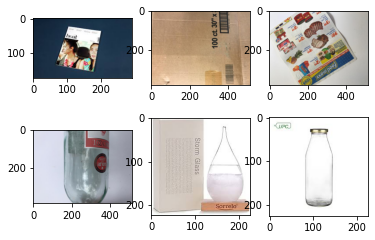

In [24]:
# plot some random image at random classes
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [33]:
# use ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range = 20,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(base_path,
                                                   target_size=(299,299),
                                                   batch_size=100,
                                                   class_mode='categorical',
                                                   subset='training',
                                                   shuffle=True,
                                                   seed=0)

validation_generator = train_datagen.flow_from_directory(base_path,
                                                        target_size=(299,299),
                                                        batch_size=100,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True,
                                                        seed=0)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(299,299),
                                                  batch_size=100,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=0)

labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
print(labels)

Found 5269 images belonging to 6 classes.
Found 1315 images belonging to 6 classes.
Found 70 images belonging to 1 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [60]:
# Use InceptionResNetV2 transfer learning to set our model
base_model = InceptionResNetV2(weights='imagenet', include_top = True, classifier_activation='softmax', input_shape=(299, 299, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

# Freeze all layers in the InceptionResNetV2 base model
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Define trainable model which links input from the  base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

# Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print (model.summary())

_________
activation_1085 (Activation)    (None, 8, 8, 192)    0           batch_normalization_1085[0][0]   
__________________________________________________________________________________________________
activation_1088 (Activation)    (None, 8, 8, 256)    0           batch_normalization_1088[0][0]   
__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, 8, 8, 448)    0           activation_1085[0][0]            
                                                                 activation_1088[0][0]            
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, 8, 8, 2080)   933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, 8, 8, 2080)   0           block8_4_ac[0][0]                


In [27]:
# set early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [61]:
# fit model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks = [early_stop],
                    verbose=1)


Epoch 1/10
15/53 [=======>......................] - ETA: 10:01 - loss: 1.6933 - accuracy: 0.4933

KeyboardInterrupt: 

In [29]:
# save best model
model.save('InceptionResNetV2.h5')
print('model saved')

model saved


In [35]:
# evaluate the model
score = model.evaluate_generator(validation_generator, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

14/14 [==============================] - 201s 14s/step - loss: 0.9386 - accuracy: 0.6966
Test loss:  0.9385632872581482
Test accuracy:  0.6965779662132263


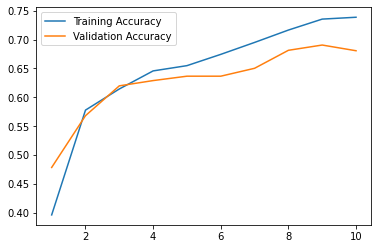

In [36]:
# plot data to see relationships in training and validation data
epoch_list = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epoch_list, history.history['accuracy'], epoch_list, history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

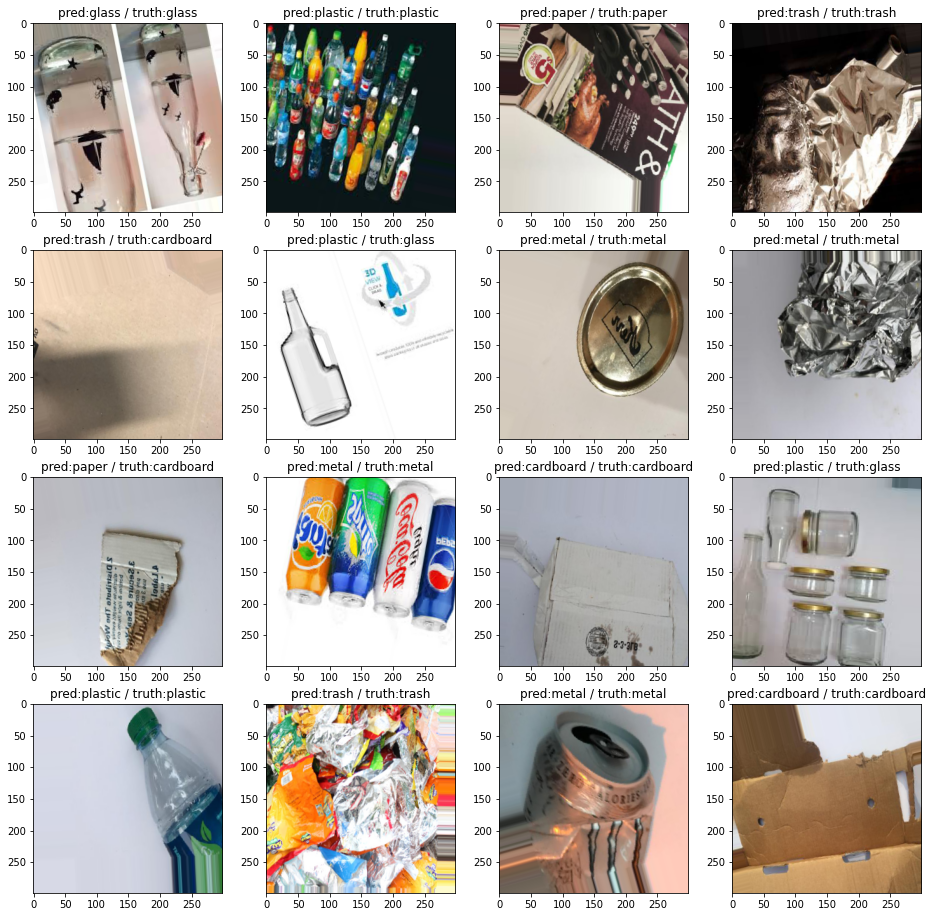

In [51]:
X_test, y_test = validation_generator.__getitem__(1)

preds = model.predict(X_test)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(y_test[i])]))
    plt.imshow(X_test[i])

In [59]:
import time

t1 = time.time()
model.predict(X_test)
# Testing has finished 
t2 = time.time()
print( 'Time taken was {:.3f} seconds per image,'.format(( t2 - t1)/16))

Time taken was 0.664 seconds per image,
